In [38]:
import matplotlib.pyplot as plt
plt.style.use(['classic'])
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy import interpolate
from theano.compile.ops import as_op
import theano.tensor as tt
from scipy import stats

from scipy.linalg import block_diag,eigh

In [4]:
#checking verison of pymc3
print('Running on PyMC3 v{}'.format(pm.__version__))
#inputting data
#data_base = np.loadtxt("Lyman_alpha_result_balout_z=3.2-3.3_testing.txt")
data_z = np.loadtxt("zratiosnr22.txt")
data_all = np.loadtxt("./jiani0126/dr14_1075-1150_co_10000_0.9_testing_snr2.2_waveflux.txt")
data_error = np.loadtxt("test1.txt")
covariance = np.loadtxt("test2.txt")

data_z = data_z[:,0]
print (data_z)
i = range(0, len(data_all))
data_indi_flux = np.split(data_all[i,1], len(data_z))
data_indi_wave = np.split(data_all[i,0], len(data_z))
data_error_split = np.split(data_error, len(data_z))
covariance_split = np.split(covariance, len(data_z))

#print (covariance_split)


data_indi_flux = data_indi_flux[3:]
data_indi_wave = data_indi_wave[3:]
covariance_split = covariance_split[3:]
data_z = data_z[3:]
#print (np.min(covariance_split[7]))

#using schaye metal correction
data_indi_tau = [0.146,0.187,0.229,0.280,0.36]
data_redshift_base = [2.0,2.2,2.4,2.6,2.8]
data_error_base = [0.018,0.013,0.009,0.01,0.012]
data_indi_flux_final = np.append(data_indi_flux,np.array(data_indi_tau))
#data_error_final=np.append(data_error_split,np.array(data_error_base))

Running on PyMC3 v3.5
[2.54882838 2.64806702 2.7478156  2.84952959 2.95062568 3.04919773
 3.14875346 3.2480309  3.3450856  3.4461385  3.5517966  3.64821476
 3.74814819 3.84554038 3.94690707 4.08444481 4.28969931 4.49270692
 4.69101035]


In [5]:
data_error_base = block_diag(np.array(data_error_base))
contrain_co1 = np.zeros((5,5))
indice = np.diag_indices(5)

contrain_co1[indice] = np.array(data_error_base**2)
print (contrain_co1)

[[3.24e-04 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 1.69e-04 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 0.00e+00 8.10e-05 0.00e+00 0.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 1.00e-04 0.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.44e-04]]


In [6]:
covariance_re = []
for i in range (0,len(data_z)):
    covariance_re.append(np.reshape(covariance_split[i],(282,282)))

    
covariance_re.append(contrain_co1)



In [7]:
# costruct the final covariance matrix
covariance_final = block_diag(*covariance_re)

print (np.array(covariance_final))

[[8.16035536e-05 5.21588045e-05 3.75270793e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.21588045e-05 7.42082266e-05 4.67413556e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.75270793e-05 4.67413556e-05 7.07921863e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 8.10000000e-05
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  1.00000000e-04 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.44000000e-04]]


In [8]:
def converter(cov):
    e1,v1 = np.linalg.eig(cov)
    print (np.min(e1))
    a = v1.T
    t = a@cov@a.T
    tnew = abs(t)
    return a.T@tnew@a

In [9]:
cov_abs = converter(covariance_final)

-3.1692420777550247e-09


In [10]:
e,v = np.linalg.eig(cov_abs)

In [11]:
print (cov_abs,covariance_final,np.min(e))

[[8.16035536e-05 5.21588045e-05 3.75270793e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.21588045e-05 7.42082266e-05 4.67413556e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.75270793e-05 4.67413556e-05 7.07921863e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 8.10000000e-05
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  1.00000000e-04 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.44000000e-04]] [[8.16035536e-05 5.21588045e-05 3.75270793e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.21588045e-05 7.42082266e-05 4.67413556e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.75270793e-05 4.67413556e-05 7.07921863e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 8.10000000e-05
  0.00000000e+00 0.00000000e+00]

In [12]:
covtol1 = np.loadtxt("./jiani0126/dr14_1075-1150_co_10000_0.9_testing_snr2.2_tol_1.txt")

In [13]:
#covtol2= np.loadtxt("./jiani0126/dr14_1075-1150_co_10000_0.9_testing_snr2.2_tol_2.txt")

In [14]:
print (len(covtol1))

53580000


In [15]:
#covtol = np.append(covtol1,covtol2)

covtolsplit = np.split(covtol1,19)

In [16]:
covtest= []
for ii in range(3,len(covtolsplit)):
    covtest.append(np.transpose(np.split(covtolsplit[ii],10000)))

In [17]:
final_cov = np.dot(np.vstack(covtest),np.transpose(np.vstack(covtest)))/(len(np.vstack(covtest))-1)

In [18]:
print (len(final_cov))

4512


In [19]:
covt = []
covt.append(final_cov)
covt.append(contrain_co1)

In [20]:
# costruct the final covariance matrix
cov_final = block_diag(*covt)

print (len(np.array(cov_final)))

4517


In [ ]:
e,v = np.linalg.eig(cov_final)

In [138]:
np.linalg.cholesky(cov_final)

array([[ 1.23563119e-02,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.48038953e-06,  1.23703682e-02,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.76778918e-04, -2.06249610e-05,  1.23010855e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         9.00000000e-03,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  1.00000000e-02,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  1.20000000e-02]])

In [135]:
print (len(np.ravel(np.array(data_indi_flux_final))))

4517


In [ ]:



n = 12



#assuming function of tau
def func(x,amp,index):
    func = amp * ((1 + x)/(1+3.05)) ** index
    return func





#x = data_indi_wave[5] / 1215.67 * (1 + data_z[5]) - 1
#fc1 = data_indi_flux[5] / np.exp(-func(x, 3, 5))



#setting up pymc3 model
@as_op(itypes=[tt.dscalar]*(n+2), otypes=[tt.dvector])
def fc(*para):
    

        
        #x = data_indi_wave[5] / 1215.67 * (1+data_z[5]) - 1
        #converting restframe wavelength to absorption redhsift
        x2 = np.array(data_indi_wave) / np.array(1215.67 / (1+np.array(np.split(data_z, len(data_z))))) - 1

        
               
        
        
        #wavelength for continuum model
        xi = np.linspace(data_indi_wave[5][0], data_indi_wave[5][len(data_indi_wave[5])- 1], n)
        
        result_final = interp1d(xi, np.array(para[2:(n+2)]), kind='cubic')(data_indi_wave[5])*np.exp(-func(x2,para[0],para[1]))
        #result_final = result(data_indi_wave[5])*np.exp(-func(x2,amp,index))
        #print (result_final)
        #adding the constraint from Faucher2008
        x1 = np.array(data_redshift_base)
        #print (result_final)
        result_final1= np.append(result_final,func(x1, para[0], para[1]))
        

        return result_final1


if __name__ == '__main__':
    with pm.Model() as model:
        #the prior distribution of all the parameters
        para = []
        amp = pm.Uniform('amp',0.2,0.6)
        index = pm.Uniform('index', 2,5)
        n = 12
        para.append(amp)
        para.append(index)
        for i in range(0,n):
            para.append(pm.Uniform(str(i), 0.6, 2.8))
        #print (para)

        fc = fc(*para)
        #fit the model to observed data
        pymc_data = pm.MvNormal(str('output_data'), mu=fc, cov =  np.array(cov_final), observed=np.ravel(np.array(data_indi_flux_final)))

        trace = pm.sample(90000,burn=9000,tune=4000, chain=1, cores=2)

pm.traceplot(trace)
plt.show()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [11]
>Slice: [10]
>Slice: [9]
>Slice: [8]
>Slice: [7]
>Slice: [6]
>Slice: [5]
>Slice: [4]
>Slice: [3]
>Slice: [2]
>Slice: [1]
>Slice: [0]
>Slice: [index]
>Slice: [amp]
Sampling 2 chains:  24%|██▎       | 44548/188000 [19:53:24<58:36:42,  1.47s/draws]

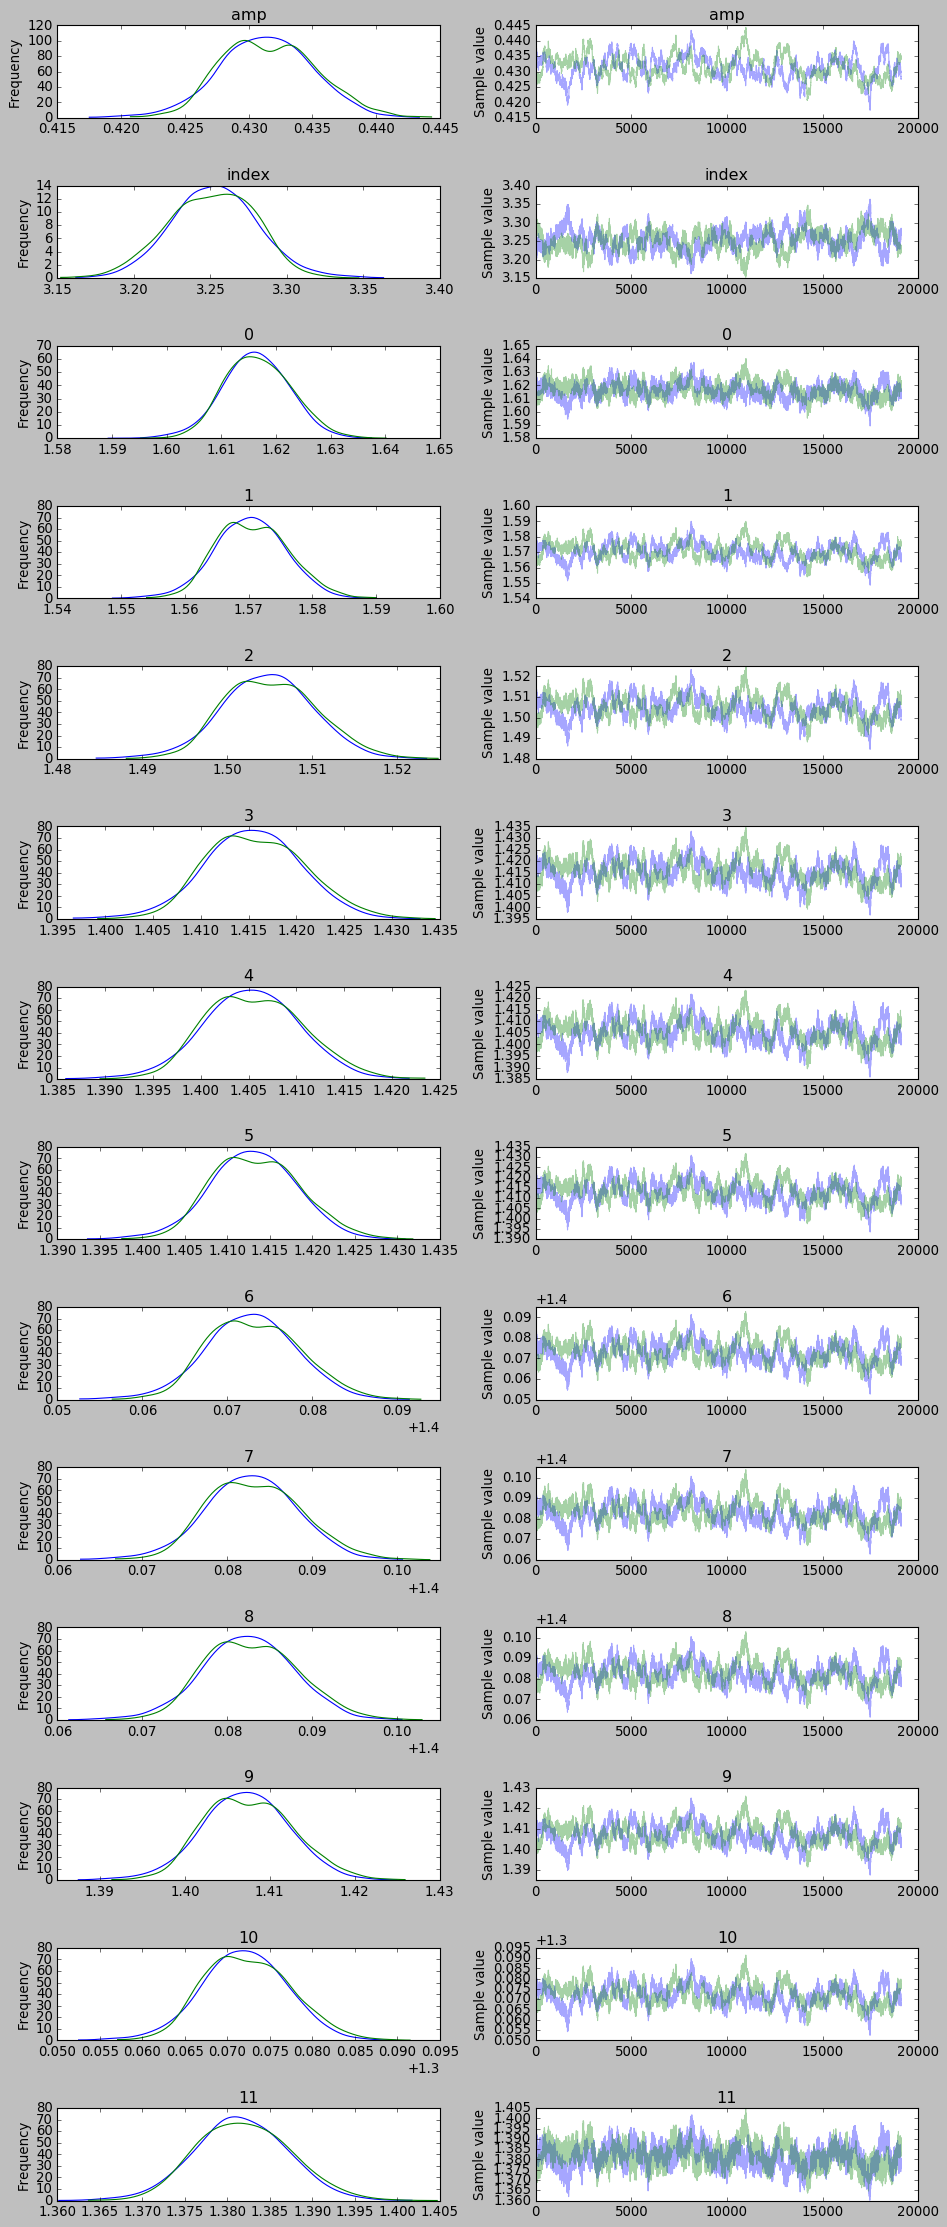

In [65]:
pm.traceplot(trace)
#pm.plot_posterior(trace)
plt.savefig('trace1.pdf')

plt.show()

In [109]:
print (cov_final[0][4000:])

[-3.82146595e-06 -6.07731087e-06  8.38611279e-06  7.87370226e-06
  1.88743990e-05  2.28694863e-06 -3.84232816e-06  6.06208388e-07
 -9.33601658e-06 -7.84265734e-06  4.96472595e-06  3.68498771e-06
 -9.47094073e-07  4.36391854e-06  5.67688024e-06  2.68971111e-06
  9.25461350e-06 -1.77672928e-07  3.61377225e-06  9.29393427e-06
 -2.90687019e-06  1.01497348e-05  4.13219088e-06  3.34049617e-07
 -1.00608690e-05  1.51947535e-06  5.09204004e-06  4.24451094e-06
 -2.61597595e-06  1.62371406e-05 -7.81366683e-06  2.33210214e-06
 -2.21565814e-06 -6.46740672e-06 -8.10947083e-06 -1.86859127e-06
 -3.92707051e-06  1.99114039e-06  2.89517221e-06 -2.22115505e-06
  1.44635700e-05 -3.95378743e-06 -3.36101124e-06  5.17896054e-07
  1.24806087e-05  1.88248246e-05  1.35320170e-05 -2.66780276e-06
 -4.41235906e-06  3.37025092e-06  8.19111651e-06  7.28979131e-06
  1.73331231e-06 -4.25944736e-06  6.53547888e-06  9.07642346e-06
  9.73621951e-06  4.29413202e-06 -2.62439415e-06  1.97696260e-07
  1.35971898e-05 -1.00417

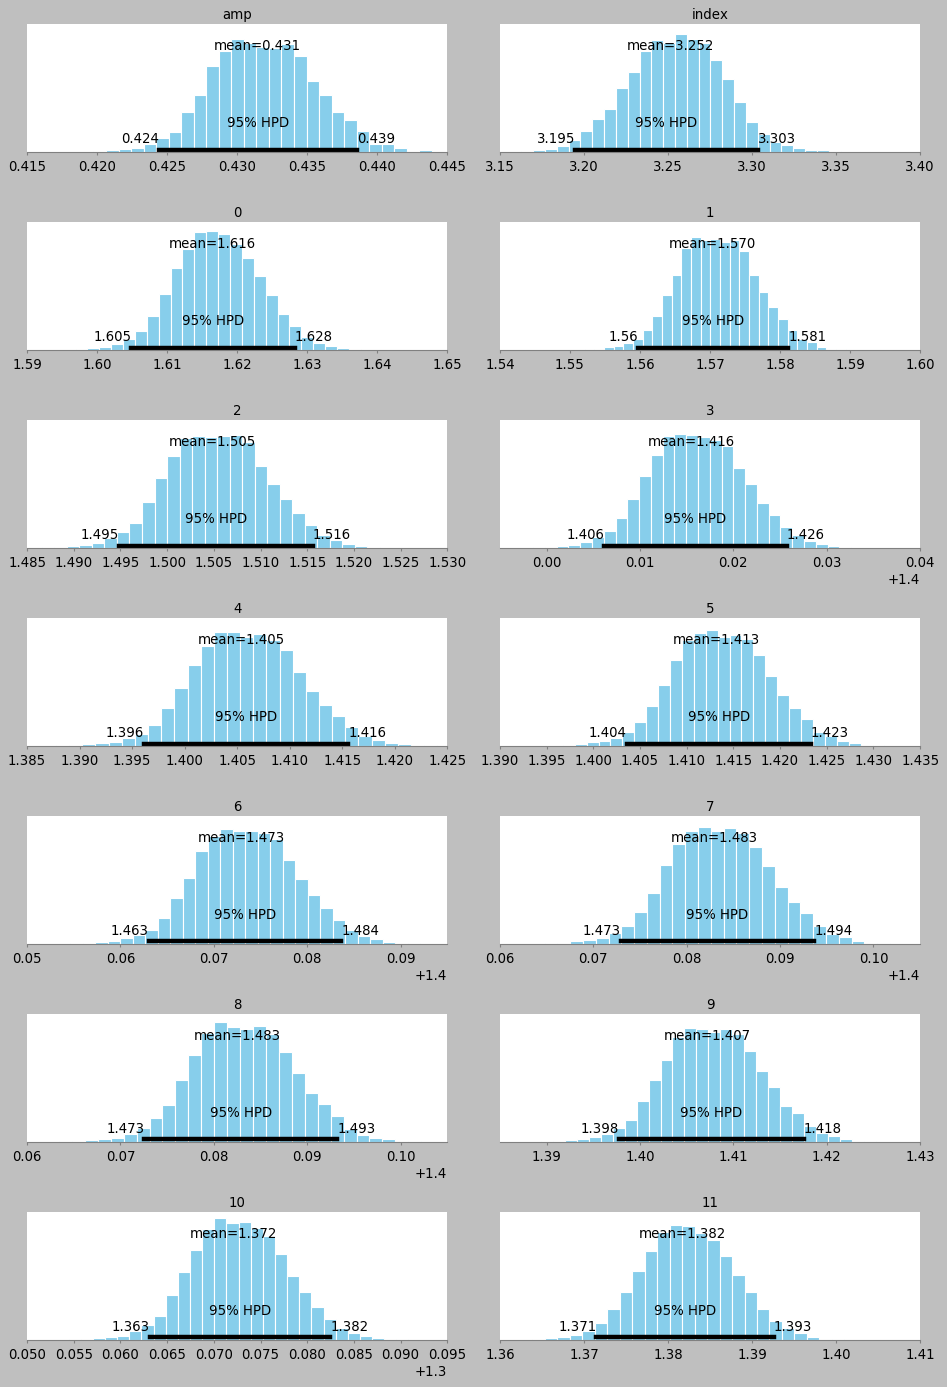

In [40]:





pm.plot_posterior(trace)
plt.savefig('trace.png',dpi=300)
plt.show()

In [24]:
from pymc3 import summary

summary(trace)

/home/jding/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/home/jding/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
amp,0.431433,0.003676,0.000307,0.424432,0.438565,75.951282,1.002724
index,3.251515,0.028060,0.002286,3.194812,3.303293,80.226066,1.002579
0,1.616435,0.005987,0.000471,1.604894,1.628236,86.455401,1.002294
1,1.570360,0.005563,0.000460,1.559685,1.581183,77.747639,1.002608
2,1.504818,0.005340,0.000441,1.494877,1.515571,78.023563,1.002817
3,1.415527,0.005051,0.000415,1.406160,1.425743,78.638583,1.002755
4,1.405387,0.005045,0.000414,1.396126,1.415579,79.143729,1.002520
5,1.413149,0.005092,0.000417,1.403577,1.423315,78.748412,1.002534
6,1.472896,0.005319,0.000438,1.463061,1.483625,78.481110,1.002635
7,1.482924,0.005357,0.000441,1.472933,1.493645,78.059576,1.002725


In [150]:
print (trace['amp'])

[0.42962329 0.42937358 0.42940665 ... 0.43613168 0.43632902 0.43632316]


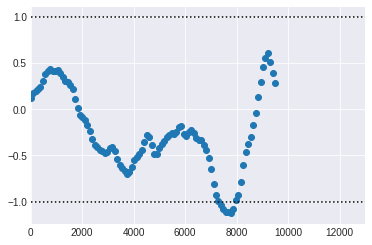

In [27]:
#convergence test
from pymc3 import geweke
    
z = geweke(trace, intervals=100)
#print (z[2])
plt.scatter(*z[2]['index'].T)
plt.hlines([-1,1], 0, 13000, linestyles='dotted')
plt.xlim(0, 13000)
plt.show()

{'amp': 1.0031470265987825, 'index': 1.0026837526247856, '0': 1.0032659706540403, '1': 1.0032806790687292, '2': 1.0031980922872983, '3': 1.003383929124796, '4': 1.0033120866402487, '5': 1.003370048540726, '6': 1.0033317945411246, '7': 1.003450948457678, '8': 1.0034696932865572, '9': 1.0032438638346657}


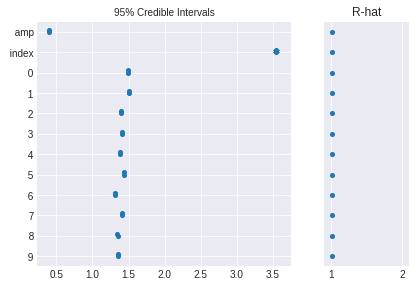

In [9]:
%matplotlib inline  
from pymc3 import forestplot
from pymc3 import gelman_rubin

print (gelman_rubin(trace))

forestplot(trace)

In [74]:
#plotting the difference between mean model and the data
def plot_MCMC_model(n,xdata, ydata, trace):
    """Plot the linear model and 2sigma contours"""
    
    
    mean = []

    for i in range(0,n+2):
         mean.append(summary(trace)['mean'][i])
            

    xi = np.linspace(xdata[5][0], xdata[5][len(xdata[5])- 1], n)
    x2 = np.array(xdata) / np.array(1215.67 / (1+np.array(np.split(data_z, len(data_z))))) - 1
    #print (continuum)
    result_final = interp1d(xi, np.array(mean[2:n+2]), kind='cubic')(xdata[5])*np.exp(-func(x2,mean[0],mean[1]))
       
    x1 = np.array(data_redshift_base)
        #print (result_final)
    result_model= np.append(result_final,func(x1, mean[0],mean[1]))
        

    
    fig, ax = plt.subplots(5, 2, figsize=(18, 20), gridspec_kw={'wspace': 0.15, 'hspace': 0.2}, sharex=False, sharey=False)

    fig.subplots_adjust(left=0.05, bottom=0.05, right=0.9, top=0.9)
    k = 0
    
    degrees = [(0, 0), (1, 0), (2, 0), (3, 0), (0, 1), (1, 1), (2, 1), (0, 2), (1, 2), (0, 3)]
    for index in range(ax.shape[0]):
        for jndex in range(ax.shape[1]):
            ax[index][jndex].plot(np.array(xdata[k]/1215.67*(1+data_z[k]))-1, ydata[k], label=str('{:.2f}'.format(data_z[k])) + ' data')
            ax[index][jndex].plot(np.array(xdata[k]/1215.67*(1+data_z[k]))-1, result_model[k*282:(k+1)*282], label='model')
            
        # ax[index][jndex].axvline(rest_wave[i]*3.309,c='k',linestyle = '--',label = str(names[i]))
        # ax[index][jndex].axvline(rest_wave[i]*3.309,c='k',linestyle = '--')
        # ax[index][jndex].annotate('0.25 on axes', (0.25,4530), textcoords='data', size=20)
            #ax[index][jndex].legend()
            ax[index][jndex].set_xlabel('redshift')
            ax[index][jndex].set_ylabel('flux')
            ax[index][jndex].legend( prop={'size': 20})
        #ax[index][jndex].set_xticklabels('{:.2f}'.format(np.array(data_indi_wave[i]/1215.67*(1+data_z[i]))))
            
            
            k = k + 1
            
    
    
    plt.savefig('model_fittednew.pdf')
    
    plt.show()
    plt.plot(data_redshift_base,result_model[16*282:],label = 'mean model')
    plt.plot(data_redshift_base,data_indi_tau,label = 'data')
    plt.errorbar(data_redshift_base,data_indi_tau,yerr=np.array([0.018,0.013,0.009,0.01,0.012]),capsize = 2.0,label = 'faucher2008 data')
    plt.savefig('model_fitted4.png')
    plt.show()
    
    
   # plt.fill_between(xdata, mu - sig, mu + sig, color='lightgray')
    
    

    return  result_model,interp1d(xi, np.array(mean[2:n+2]), kind='cubic')(xdata[5])

/home/jding/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/home/jding/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))


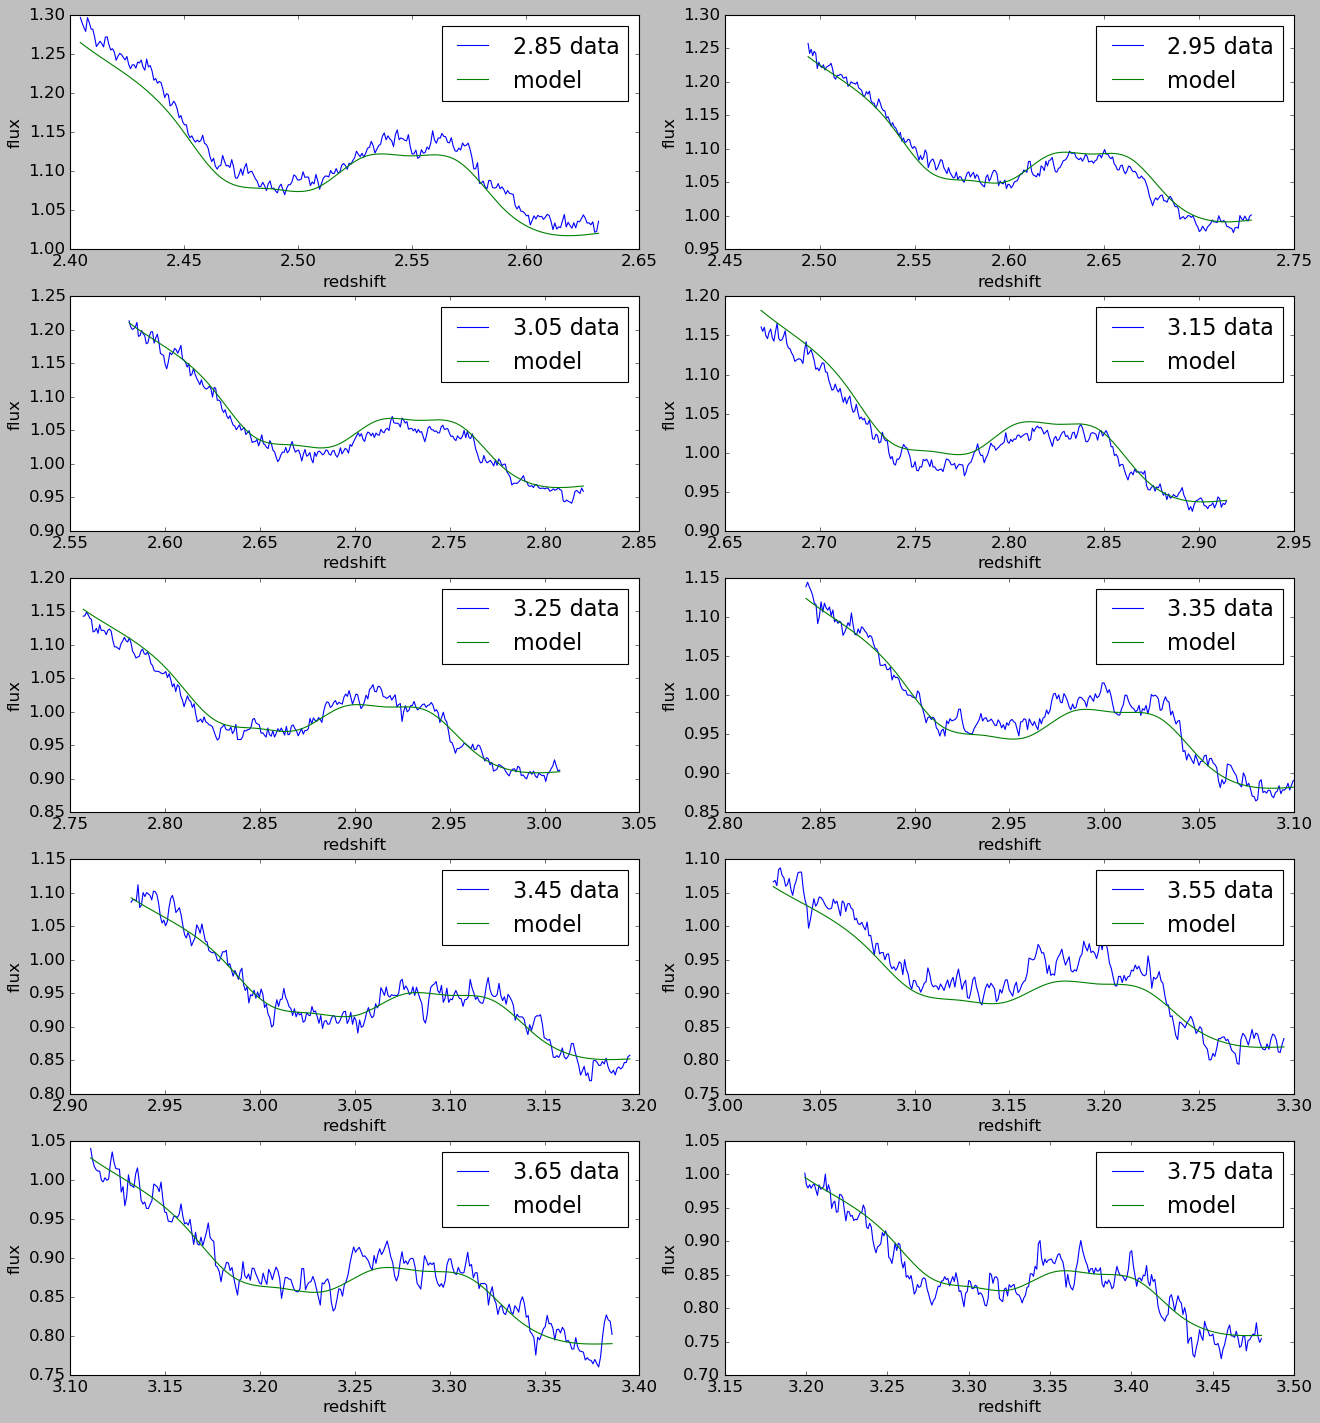

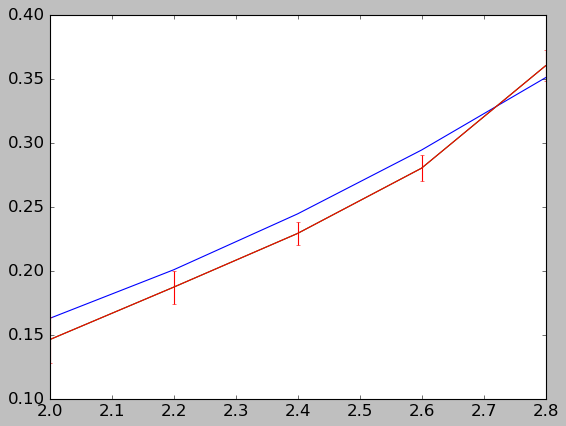

In [75]:
conti = plot_MCMC_model(12,data_indi_wave, data_indi_flux, trace)[1]

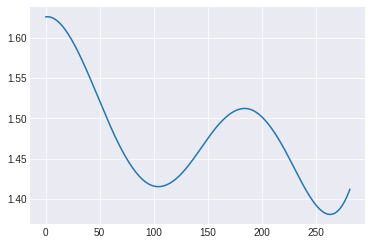

In [117]:
plt.plot(np.arange(0,282,1),conti)
plt.show()

In [118]:
np.savetxt("conti_model_new",conti, delimiter = " ", newline = '\n')

In [44]:
def deltaalpha_plot(conti,xdata,dataflux,ref,data_zf):
    
    x2 = np.array(xdata) / np.array(1215.67 / (1+np.array(np.split(data_zf, len(data_zf))))) - 1
    tau = -np.log(np.array(dataflux)/conti)
    xalpha = np.ravel(x2)
    tautotal = np.ravel(tau)
    deltatau = tautotal - np.mean(tautotal[np.where((ref-0.005 < xalpha)&(xalpha< ref+0.005))])
    print (np.mean(tautotal[np.where((ref-0.005 < xalpha)&(xalpha< ref+0.005))]))
    
    plt.figure(figsize=(13,12))
    plt.scatter(xalpha[:6000],deltatau[:6000],s=3)
    #plt.xlim(0,2.8)
    plt.xlabel('zalpha')
    plt.ylabel('deltatau')
    #plt.savefig('/Users/Jenny/desktop/deltaualpha_new.png')
    plt.show()
    return xalpha,tautotal,deltatau

0.3605521140802468


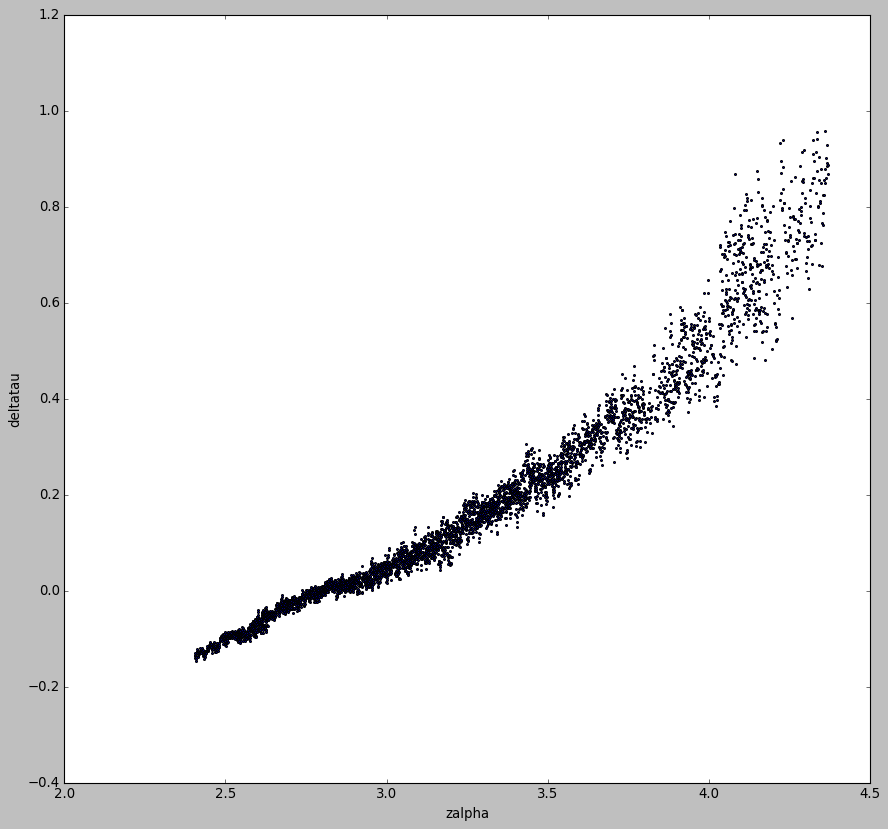

In [45]:
xalpha,tau,deltatau = deltaalpha_plot(conti,data_indi_wave,data_indi_flux,2.8,data_z)

In [46]:
print (len(np.transpose(covtest[0])+np.repeat([data_indi_flux[0]],10000,axis =0)))

10000


In [49]:
def diagonal_error(xalpha,flux,cov,bins,conti,alphabin):
    
    fluxi = []
    for ii in range(0,len(flux)):
        fluxi.append(np.transpose(covtest[ii])+np.repeat([flux[ii]],10000,axis =0))
    
    fluxto = np.hstack(fluxi)
    ind = np.unravel_index(np.argsort(xalpha, axis=None), xalpha.shape)
    
       
    
    
#np.argsort(xalpha, axis=None)
    #print (fluxto)
    alphabine = []
    for jj in range(0,len(fluxto)):
        tauto = -np.log(np.split(np.array(fluxto[jj]),16)/conti)
        #print (np.split(np.array(fluxto[jj]),16))
        tautotal = np.ravel(tauto)
        alphabini = tautotal[ind]
        
        xalphabin = stats.binned_statistic(xalpha[ind], xalpha[ind], statistic='mean',bins = bins)
        
        alphabinc = stats.binned_statistic(xalpha[ind], alphabini, statistic='mean',bins = bins)
        
        alphabine.append(alphabinc[0] - alphabin)
        
    #print (np.transpose(np.vstack(alphabine)))
    #print (np.vstack(np.transpose(alphabine)))
    binerr = np.dot(np.vstack(np.transpose(alphabine)),np.vstack(alphabine))/(10000-1)

    return binerr
        
    

In [77]:
binerr = diagonal_error(xalpha,data_indi_flux,covtest,16,conti,alphabin[0])

In [78]:
#print ( len())

In [79]:
binerrf = np.sqrt(np.diagonal(binerr))
print (binerrf*1.1)

[0.00056371 0.00043404 0.00044034 0.0004812  0.00062896 0.0008171
 0.00094365 0.00107344 0.00157538 0.00203357 0.00306374 0.00473909
 0.00633707 0.01011883 0.0133305  0.02029258]


In [80]:
np.savetxt('bin_alpha_err.txt', np.c_[xalphabin[0],binerrf*1.4], delimiter = " ", newline = '\n')

In [81]:
np.savetxt('bin_alpha.txt', np.c_[xalphabin[0],alphabin[0]], delimiter = " ", newline = '\n')

In [82]:
font = {'size'   : 15}

plt.rc('font', **font)

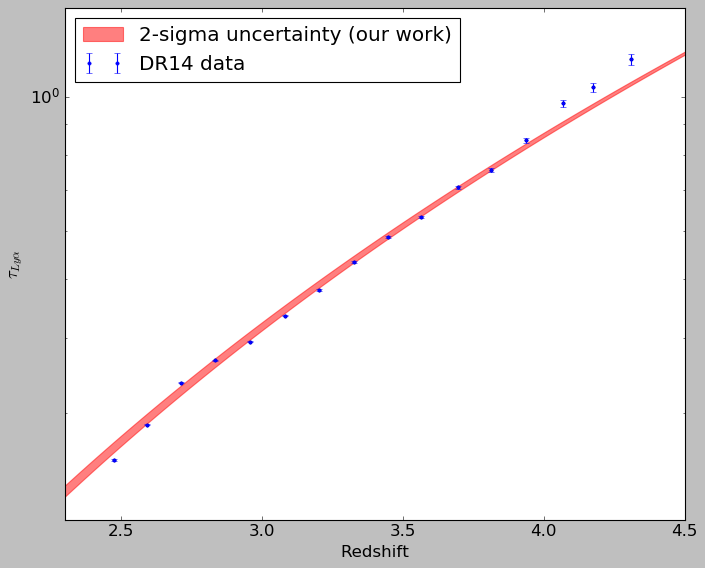

In [90]:
ind = np.unravel_index(np.argsort(xalpha, axis=None), xalpha.shape)

#np.argsort(xalpha, axis=None)
alphabini = tau[ind]
xalphabin = stats.binned_statistic(xalpha[ind], xalpha[ind], statistic='mean',bins = 16)
alphabin = stats.binned_statistic(xalpha[ind], alphabini, statistic='mean',bins = 16)

plt.figure(figsize=(10,8))
xinput = np.arange(2.3,5.0,0.01)

tau2 = 0.75124*((1+np.array(xinput))/(1+3.5))**2.9-0.132
tau3 = 0.0018*(1+xinput)**3.92

linewidth = 2
plt.xlim(2.3,4.5)
#plt.scatter(xalpha[ind[0]],alphabini,s=3)
plt.ylim(0.2,1.4)
plt.scatter(xalphabin[0],alphabin[0],s=5)
plt.errorbar(xalphabin[0],alphabin[0],yerr = binerrf*1.4,fmt='.',capsize=3,label = 'DR14 data')
#plt.plot(xinput,func(xinput,0.43,3.53),c='r')
plt.fill_between(xinput,func(xinput,0.427,3.29),func(xinput,0.44,3.23),color='r',alpha=0.5,label ='2-sigma uncertainty (our work)')
#plt.plot(xinput,tau2,c='b',label ='Becker2013')
#plt.plot(xinput,tau3,c='g',label='Faucher-Giguere2009')
plt.xlabel('Redshift')
plt.ylabel(r'$\tau_{Ly\alpha}$')
plt.yscale('log')
plt.legend(loc=2)
plt.savefig('comparison.png')
plt.show()



In [30]:
#calculating the chi square for individual data points
def chi_square(n,xdata, ydata, error, trace):
    chi_indi = []
    model_mean = plot_MCMC_model(n,xdata, ydata, trace)
   
    
    for i in range(0,len(ydata)):
        chi_indi.append(np.square(ydata[i]-model_mean[i*282:(i+1)*282])/np.square(error[i]))

    fig, ax = plt.subplots(7, 2, figsize=(13, 10), gridspec_kw={'wspace': 0.08, 'hspace': 0.25}, sharex=False, sharey=False)

    fig.subplots_adjust(left=0.05, bottom=0.05, right=1.2, top=0.9)
    k = 0
    
    
    
    
    print (len(xdata))
    degrees = [(0, 0), (1, 0), (2, 0), (3, 0), (0, 1), (1, 1), (2, 1), (0, 2), (1, 2), (0, 3)]
    for index in range(ax.shape[0]):
        for jndex in range(ax.shape[1]):
       
            #ax[index][jndex].plot(np.array(data_indi_wave[k]/1215.67*(1+data_z[k]))-1, data_indi_flux[k], label=str('{:.2f}'.format(data_z[k])) + ' data')
            ax[index][jndex].plot(np.array(xdata[k]/1215.67*(1+data_z[k]))-1, chi_indi[k], label='individual chi square for each data point')
        
                #ax[index][jndex].plot(np.array(constrainx[k]), chi_indi[k], label='individual chi square for each data point')
        # ax[index][jndex].axvline(rest_wave[i]*3.309,c='k',linestyle = '--',label = str(names[i]))
        # ax[index][jndex].axvline(rest_wave[i]*3.309,c='k',linestyle = '--')
        # ax[index][jndex].annotate('0.25 on axes', (0.25,4530), textcoords='data', size=20)
            ax[index][jndex].legend()
            ax[index][jndex].set_xlabel('redshift')
            ax[index][jndex].set_ylabel('')
        #ax[index][jndex].set_xticklabels('{:.2f}'.format(np.array(data_indi_wave[i]/1215.67*(1+data_z[i]))))

    
            k = k + 1
    plt.show(fig)
    plt.plot(data_redshift_base,np.square(data_indi_tau-model_mean[15*282:])/np.square(data_error_base))
    plt.xlabel('redshift')
    
    
    plt.show()
  
    
    

In [311]:
def compute_sigma_level(trace1, trace2, nbins=30):
    """From a set of traces, bin by number of standard deviations"""
    L, xbins, ybins = np.histogram2d(trace1, trace2, nbins)
    L[L == 0] = 1E-16

    shape = L.shape
    L = L.ravel()

    # obtain the indices to sort and unsort the flattened array
    i_sort = np.argsort(L)[::-1]
    i_unsort = np.argsort(i_sort)

    L_cumsum = L[i_sort].cumsum()
    L_cumsum /= L_cumsum[-1]

    xbins = 0.5 * (xbins[1:] + xbins[:-1])
    ybins = 0.5 * (ybins[1:] + ybins[:-1])

    return xbins, ybins, L_cumsum[i_unsort].reshape(shape)


In [312]:
def plot_MCMC_trace(xdata, ydata, trace, scatter=False, **kwargs):
    """Plot traces and contours"""
    #_, ax = plt.subplots(1, 2, figsize=(10, 4))
    xbins, ybins, sigma = compute_sigma_level(trace['amp'], trace['index'])
    plt.contour(xbins, ybins, sigma.T, levels=[0.683, 0.955], **kwargs)
    if scatter:
        ax.plot(trace['amp'], trace['index'], ',k', alpha=0.1)
    plt.xlabel(r'$\alpha$')
    plt.ylabel(r'$\beta$')
    

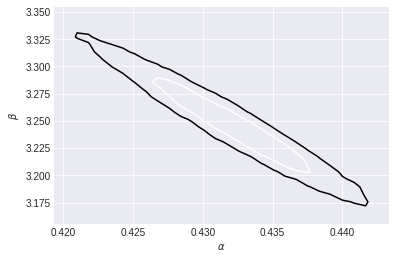

In [313]:
plot_MCMC_trace(data_indi_wave,data_indi_flux,trace)

In [336]:
print (len(trace['index']))

49478


In [66]:
import corner
def corner_plot(n,trace):
    cornerplot = []
    #cornerplot.append(trace['amp'])
    cornerplot.append(trace['index'])
    cornerplot.append(trace['amp'])

    names = []
    #for i in range(0,1):
        #cornerplot.append(trace[str(i)])
        #names.append(str(i))
    
    figure = corner.corner(np.transpose(np.vstack(np.array(cornerplot))).reshape(len(trace['amp']),2),labels=["Amp", "Index",*names],show_titles=True, title_kwargs={"fontsize": 12},title_fmt = '.3f', quantiles = [0.32,0.5,0.68])
    plt.savefig('Corner_plot_TEST.pdf')
    plt.show()
    
   
    
    
    return cornerplot



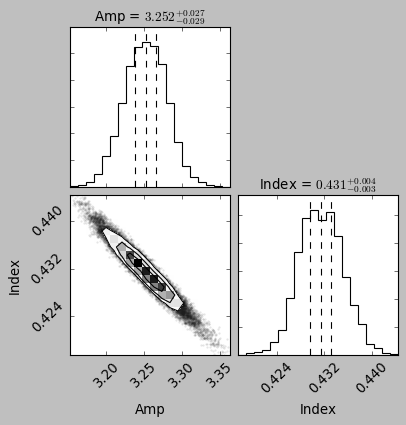

[array([3.23158645, 3.23048001, 3.23199491, ..., 3.22022859, 3.21930528,
        3.22346418]),
 array([0.43375582, 0.43398637, 0.43390671, ..., 0.43473705, 0.4348512 ,
        0.43478049])]

In [67]:
corner_plot(12,trace)